# Prerequisites

In [1]:
%load_ext autoreload
%autoreload 2

import box_ops
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.multiprocessing as mp
import torch.nn.functional as F
import torchvision.transforms as transforms
from data import get_waste, standardize_inv
from tqdm.notebook import tqdm
from model import SimpleRCNN
from selectivesearch import SelectiveSearch
from utils import label_proposals, show_annotation, show_cmap

# Load model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device:\t{device}')

Using device:	cuda


In [3]:
# checkpoint = torch.load('../models/resnet18_8455.pt',
#                         map_location=torch.device('cpu'))
checkpoint = torch.load('../models/resnet34_8782.pt',
                        map_location=torch.device('cpu'))
args = vars(checkpoint['args'])

model = SimpleRCNN(args['n_layers'], args['n_classes'])
# optimizer = get_optimizer(args['optimizer_type'], model, args['pretrained_lr'],
#                           args['new_layer_lr'])

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Load data

In [4]:
_, _, test_dataset, _, _, test_loader = get_waste(batch_size=1,
                                                  num_workers=0,
                                                  supercategories=True)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


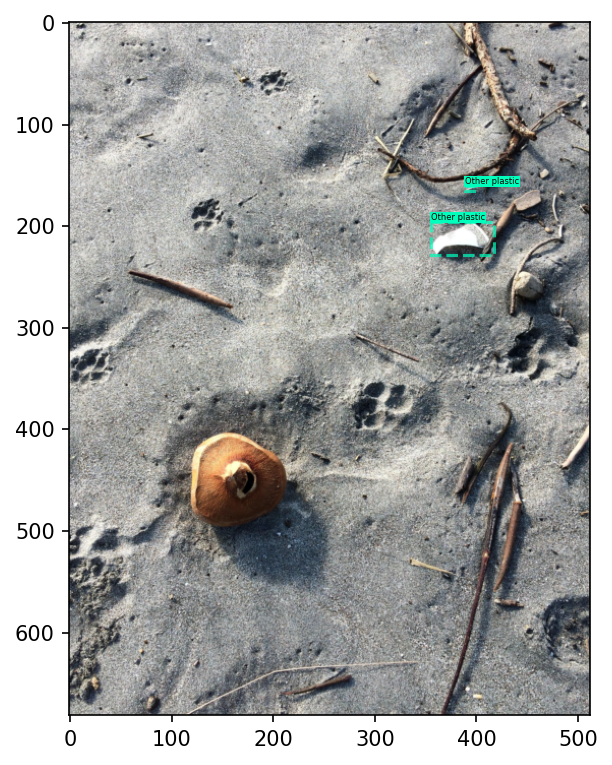

In [5]:
titer = iter(test_loader)
idx = 5
for _ in range(idx):
    ims, targets = next(titer)

im, _ = standardize_inv(ims[0], None)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=150)
ax.imshow(np.moveaxis(im.numpy(), 0, 2))
show_annotation(targets[0], ax, names=test_dataset.cat_names)

# Inference

In [6]:
# Resize transform
resize = transforms.Resize((256, 256), antialias=True)

pool = mp.Pool(mp.cpu_count())

ss = SelectiveSearch(mode='f', nkeep=3000)

in_batch_size = 32

In [7]:
all_preds, all_confs = [], []
with torch.no_grad():
    # Get object proposals for all images in the batch
    proposals_batch = pool.map(ss, [
        (np.moveaxis(im.numpy(), 0, 2) * 255).astype(np.uint8) for im in ims
    ])  # Multiprocessing for Selective search

    # Get labels and subsample the region proposals for training purposes
    proposals_batch, proposals_batch_labels = label_proposals(proposals_batch,
                                                              targets,
                                                              filter=False)
    boxes_batch = proposals_batch

    # Labels
    y_true = torch.tensor(np.concatenate(proposals_batch_labels))

    # Crop out proposals and resize.
    X = []
    valid = []
    idx = 0
    for im, boxes in zip(ims, boxes_batch):
        for (x, y, w, h) in boxes:
            candidate = im[:, y:y + max(h, 2), x:x + max(w, 2)]
            if any(torch.tensor(candidate.size()) == 0):
                idx += 1
                continue
            X.append(resize.forward(candidate))
            valid.append(idx)
            idx += 1
    X = torch.stack(X)
    y_true = y_true[torch.tensor(valid)]

    # Dont shuffle here
    shuffle = torch.arange(y_true.size(0))

    for j in tqdm(range(
            shuffle.size(0) // in_batch_size +
            bool(shuffle.size(0) % in_batch_size))):
        indices = shuffle[j * in_batch_size:(j + 1) * in_batch_size]
        X_batch, y_batch_true = X[indices], y_true[indices]

        X_batch = X_batch.to(device)

        output = model(X_batch)

        p = F.softmax(output, dim=1).max(1)
        preds = p.indices.cpu()
        confs = p.values.cpu()
        all_preds.append(preds)
        all_confs.append(confs)

  0%|          | 0/82 [00:00<?, ?it/s]

In [32]:
preds = torch.cat(all_preds).numpy()
scores = torch.cat(all_confs).numpy()
pred_boxes = np.vstack(boxes_batch)[np.array(valid)]

In [33]:
# Non-max suppresion
preds_keep = []
scores_keep = []
pred_boxes_keep = []
for category in np.unique(preds):
    mask = preds == category
    b, s = box_ops.nms(pred_boxes[mask], scores[mask], iou_threshold=.5)
    # print(len(s))
    # print(mask.sum())
    pred_boxes_keep.append(b)
    scores_keep.append(s)
    preds_keep = preds_keep + len(s) * [category]
preds = np.array(preds_keep)
scores = np.concatenate(scores_keep)
pred_boxes = np.vstack(pred_boxes_keep)

In [34]:
mask = (preds != 0) & (scores > .9)
preds = preds[mask]
scores = scores[mask]
pred_boxes = pred_boxes[mask]

In [35]:
h, w = targets[0]['size']
pred_dict = {'bboxes_unit': pred_boxes / np.array([w, h, w, h]), 'category_ids': preds, 'size': targets[0]['size']}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


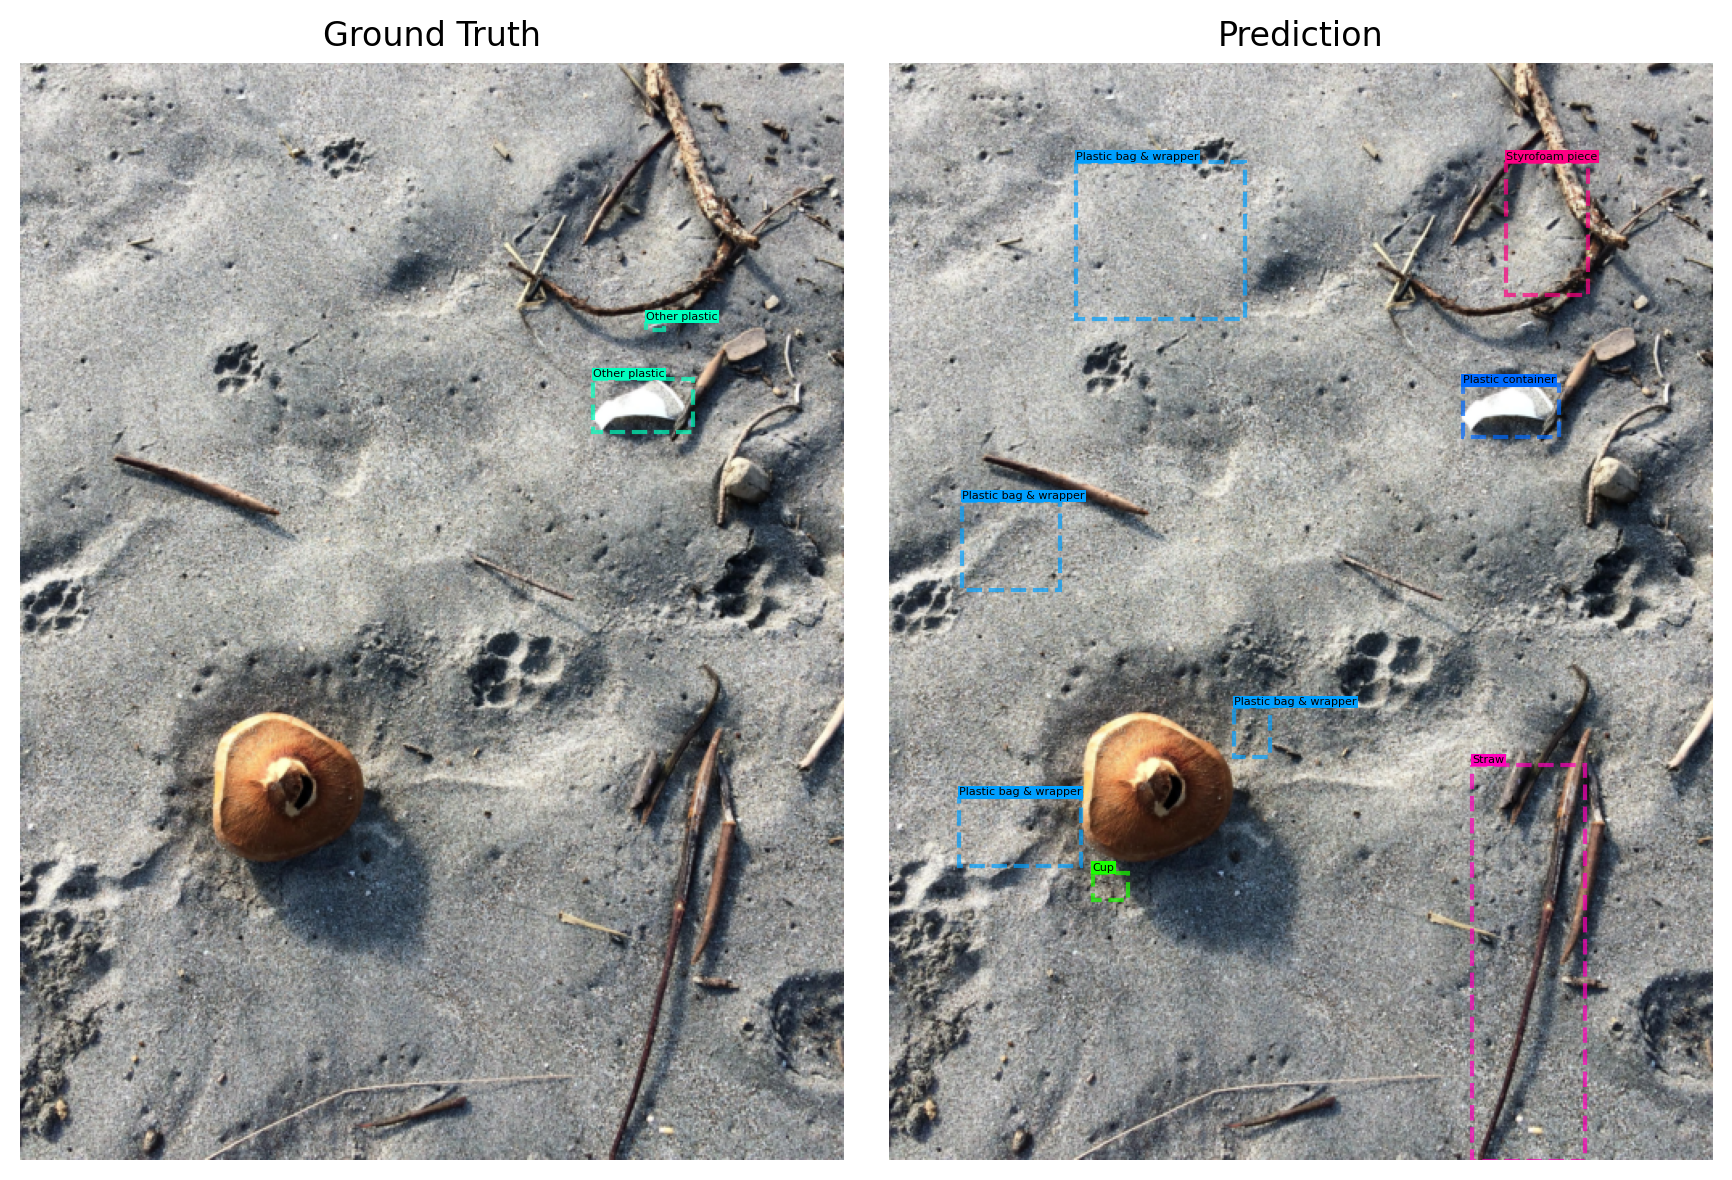

In [38]:
im, _ = standardize_inv(ims[0], None)
im = np.moveaxis(im.numpy(), 0, 2)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 6), tight_layout=True, dpi=200)
ax0.imshow(im)
ax1.imshow(im)
show_annotation(targets[0], ax0, names=test_dataset.cat_names)
show_annotation(pred_dict, ax1, names=test_dataset.cat_names)

ax0.set_title('Ground Truth')
ax1.set_title('Prediction')

ax0.axis('off')
ax1.axis('off');
fig.savefig('../figs/Preds_v_gt0.png', bbox_inches='tight')